In [61]:
import torch
import pandas as pd
from torch import nn
import scanpy as sc
import numpy as np
import torch.nn.functional as F 

/home/gilberthan/anaconda3/envs/py311/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [100/2000], Loss: 0.0242, LR: 0.005000
Epoch [200/2000], Loss: 0.0008, LR: 0.005000
Epoch [300/2000], Loss: 0.0000, LR: 0.005000
Epoch [400/2000], Loss: 0.0000, LR: 0.005000
Epoch [500/2000], Loss: 0.0000, LR: 0.003500
Early stopping at epoch 521


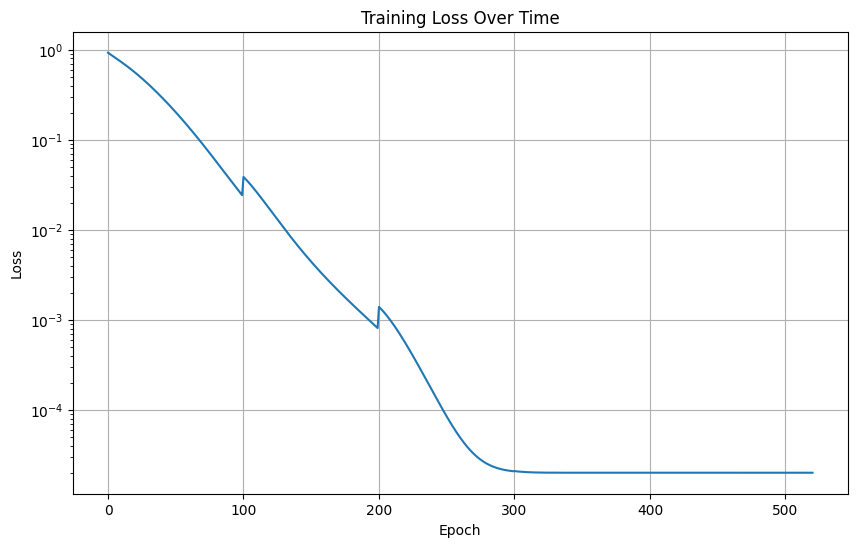


Trained parameters G:
tensor([[ 3.1895e-14,  5.1308e-01, -1.4090e-13,  4.8689e-01],
        [ 3.9371e-14,  5.7827e-01, -2.0666e-15,  4.2170e-01],
        [ 5.5742e-14,  5.2286e-01,  4.6530e-14,  4.7711e-01],
        [-1.0058e-15,  5.1543e-01, -5.5241e-14,  4.8454e-01]],
       dtype=torch.float64)

Trained weights K:
tensor([[0.2659, 0.2536, 0.2504, 0.2299],
        [0.2498, 0.2535, 0.2480, 0.2338]], dtype=torch.float64)

Predictions:
tensor([[-9.9997e-01,  3.1895e-14,  9.9997e-01],
        [-9.9997e-01,  3.9371e-14,  9.9997e-01],
        [-9.9997e-01,  5.5742e-14,  9.9997e-01],
        [-9.9997e-01, -1.0058e-15,  9.9997e-01]], dtype=torch.float64)

Original M:
tensor([[ 1.,  2.,  3.],
        [ 2.,  4.,  6.],
        [ 3.,  6.,  9.],
        [ 4.,  8., 12.]], dtype=torch.float64)


In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

class WeightedPolynomialRegression(nn.Module):
    def __init__(self, num_genes, num_cells, num_categories):
        super(WeightedPolynomialRegression, self).__init__()
        # Initialize G with smaller values
        self.G = nn.Parameter(torch.randn(num_genes, 4, dtype=torch.float64) * 0.05)
        # Initialize K with positive values
        self.K = nn.Parameter(torch.ones(num_categories, num_genes, dtype=torch.float64))
        with torch.no_grad():
            # Initialize with temperature
            self.K.data = F.softmax(self.K.data/0.5, dim=1)
    
    def forward(self, N):
        N = N.squeeze()
        # Normalize input
        N_normalized = (N - N.mean()) / (N.std() + 1e-8)
        N_poly = torch.stack([
            torch.ones_like(N_normalized),
            N_normalized,
            N_normalized**2,
            N_normalized**3
        ])
        predictions = self.G @ N_poly
        return predictions

def train_model_with_categories(
    M, N, J, 
    epochs=2000,
    lr=0.005,
    weight_decay=1e-5,
    patience=200,
    min_improvement=1e-6,
    clip_value=20.0,
    update_factor=0.98,
    scheduler_patience=100,
    scheduler_factor=0.7,
    print_every=100
):
    num_genes, num_cells = M.shape
    num_categories = J.shape[1]
    
    # Normalize M
    M_mean = M.mean(dim=1, keepdim=True)
    M_std = M.std(dim=1, keepdim=True) + 1e-8
    M_normalized = (M - M_mean) / M_std
    
    # Initialize model and optimizer
    model = WeightedPolynomialRegression(num_genes, num_cells, num_categories)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=scheduler_factor,
        patience=scheduler_patience,
        min_lr=1e-6,
        verbose=True
    )
    
    # Pre-compute masks for each category
    category_masks = [J[:, i] == 1 for i in range(num_categories)]
    
    # For early stopping
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # For loss history
    loss_history = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(N)
        
        # Vectorized loss calculation with clipping
        total_loss = torch.tensor(0., dtype=torch.float64)
        category_gene_losses = torch.zeros(num_categories, num_genes)
        
        for cat_idx, cat_mask in enumerate(category_masks):
            if cat_mask.any():
                # Compute all gene losses for this category at once
                gene_losses = torch.mean((predictions[:, cat_mask] - 
                                        M_normalized[:, cat_mask])**2, dim=1)
                
                # Clip extremely large losses
                gene_losses = torch.clamp(gene_losses, max=clip_value)
                
                # Use softmax for weights
                weights = F.softmax(model.K[cat_idx]/0.5, dim=0)
                weighted_losses = gene_losses * weights
                total_loss += weighted_losses.sum()
                
                category_gene_losses[cat_idx] = gene_losses.detach()
        
        # Add L2 regularization
        l2_reg = torch.norm(model.G)**2 * weight_decay
        total_loss = total_loss + l2_reg
        
        # Backward pass with gradient clipping
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Update learning rate
        scheduler.step(total_loss)
        
        # Store loss history
        loss_history.append(total_loss.item())
        
        # Early stopping check
        if total_loss.item() < best_loss - min_improvement:
            best_loss = total_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break
        
        # Update K matrix and print progress
        if (epoch + 1) % print_every == 0:
            with torch.no_grad():
                avg_losses = category_gene_losses.mean(dim=1, keepdim=True)
                update_mask = category_gene_losses > avg_losses
                
                # Smoother updates
                model.K.data[update_mask] *= update_factor
                model.K.data[~update_mask] *= (2 - update_factor)
                
                # Use softmax with temperature
                for cat_idx in range(num_categories):
                    model.K.data[cat_idx] = F.softmax(model.K.data[cat_idx]/0.5, dim=0)
            
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    return model, loss_history

# Example usage and visualization
if __name__ == "__main__":
    # Example data
    M = torch.tensor([
        [1.0, 2.0, 3.0],
        [2.0, 4.0, 6.0],
        [3.0, 6.0, 9.0],
        [4.0, 8.0, 12.0]
    ], dtype=torch.float64)
    
    N = torch.tensor([[1.0, 2.0, 3.0]], dtype=torch.float64)
    
    J = torch.tensor([
        [1, 0],
        [0, 1],
        [1, 0]
    ], dtype=torch.float64)
    
    # Train model
    model, loss_history = train_model_with_categories(
        M, N, J,
        epochs=2000,
        lr=0.005,
        weight_decay=1e-5,
        patience=200,
        min_improvement=1e-6,
        clip_value=20.0,
        update_factor=0.98
    )
    
    # Plot loss history
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
    # Print results
    print("\nTrained parameters G:")
    print(model.G.detach())
    print("\nTrained weights K:")
    print(model.K.detach())
    
    # Make predictions
    with torch.no_grad():
        predictions = model(N)
        print("\nPredictions:")
        print(predictions)
        print("\nOriginal M:")
        print(M)

In [3]:
adata = sc.read("../../processed_data/toy_data/20241116_bone_toy_5000.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 4986 × 1992
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'leide

In [5]:
geneMat = torch.tensor(adata.X.copy())
dpt = torch.tensor(adata.obs['pred_dpt'].values.astype('float64'))

In [16]:
catogory_str = np.repeat(['A', 'B'], 2493)

In [17]:

catogory = pd.get_dummies(catogory_str)

In [18]:
catogory_tensor = torch.tensor(catogory.values, dtype=torch.float64)

In [19]:
catogory_tensor.shape

torch.Size([4986, 2])

In [20]:
dpt.shape

torch.Size([4986])

In [21]:
geneMat.shape

torch.Size([4986, 1992])

In [22]:
N = torch.tensor([[1.0, 2.0, 3.0]])

In [23]:
model = train_model_with_categories(geneMat.T,dpt,catogory_tensor)

Epoch [100/1000], Loss: 2.3475
Epoch [200/1000], Loss: 4.1322
Epoch [300/1000], Loss: 3.5744
Epoch [400/1000], Loss: 4.1715
Epoch [500/1000], Loss: 4.1677
Epoch [600/1000], Loss: 4.2041
Epoch [700/1000], Loss: 4.1863
Epoch [800/1000], Loss: 36.7641
Epoch [900/1000], Loss: 3.9039
Epoch [1000/1000], Loss: 4.2629


WeightedPolynomialRegression()

## Create simulated datasets

In [24]:
adata_small = sc.pp.subsample(adata,fraction=0.2,copy=True)

In [26]:
cellName = adata_small.obs_names

In [28]:
sample_size = len(cellName) // 2  # 50% of the length
sampled_indices = np.random.choice(len(cellName), size=sample_size, replace=False)
sampled_vector = cellName[sampled_indices]

In [32]:
feature = adata_small.var_names

sample_size = len(feature) // 2  # 50% of the length
sampled_indices = np.random.choice(len(cellName), size=sample_size, replace=False)
sampled_feature = feature[sampled_indices]

In [39]:
permute = adata_small[sampled_vector,sampled_feature].copy()

In [40]:
permuted_cols = np.random.permutation(permute.shape[1])
permuted_matrix = permute[:, permuted_cols].copy()

In [43]:
permuted_matrix.X[0:5,0:10]

array([[-0.1851851 , -0.07246266,  0.6304078 , -0.1696592 , -0.17869857,
        -0.39011335, -0.14705946,  0.14839184, -0.2844765 , -0.00644733],
       [-0.1851851 , -0.07246266, -0.7271087 , -0.1696592 , -0.17869857,
        -0.34820375, -0.14705946, -0.60009336, -0.2844765 , -0.4657444 ],
       [-0.1851851 , -0.07246266, -0.7271087 , -0.1696592 , -0.17869857,
         0.27465189, -0.14705946, -0.60009336,  3.1022573 , -0.4657444 ],
       [-0.1851851 , -0.07246266, -0.7271087 , -0.1696592 , -0.17869857,
         0.22084308, -0.14705946,  0.5309738 , -0.2844765 , -0.4657444 ],
       [-0.1851851 , -0.07246266, -0.7271087 , -0.1696592 , -0.17869857,
         2.908886  , -0.14705946, -0.60009336, -0.2844765 , -0.4657444 ]],
      dtype=float32)

In [44]:
permute.X[0:5,0:10]

array([[-0.4843635 , -0.17446429, -0.42961827, -0.53025097,  0.15386802,
        -0.49738604, -0.2650335 , -0.18074319, -0.13501647,  0.89878887],
       [-0.4843635 , -0.17446429, -0.42961827, -0.08181527, -0.4005429 ,
         0.02528306, -0.2650335 , -0.18074319, -0.13501647, -0.39042246],
       [-0.4843635 , -0.17446429, -0.42961827, -0.53025097, -0.4005429 ,
        -0.49738604, -0.2650335 , -0.18074319, -0.13501647, -0.70098454],
       [-0.4843635 , -0.17446429, -0.42961827, -0.53025097,  1.1521194 ,
        -0.49738604,  2.3524287 , -0.18074319, -0.13501647,  1.4016274 ],
       [-0.4843635 , -0.17446429, -0.42961827, -0.53025097, -0.4005429 ,
        -0.49738604, -0.2650335 , -0.18074319, -0.13501647, -0.70098454]],
      dtype=float32)

In [49]:
adata_small[sampled_vector,sampled_feature].X = permuted_matrix.X.copy()

In [52]:
adata_small.obs["simu"] = "real"

In [55]:
adata_small.obs["simu"][sampled_vector] = "not real"

/tmp/ipykernel_1916060/1383019708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_small.obs["simu"][sampled_vector] = "not real"


In [56]:
adata_small.obs["simu"]

Unnamed: 0
BmscChondro_Long_TTAGTCTCACAAAGTA-0-2                                          real
PerichondrialP21_Matsushita_FR3CreCxcl12GfpP21_CTCAGAATCAGAGCTT-1_1-0-2    not real
Septoclasts_Kishor_Pdgfra_TCCCATGTCCTTCACG_3-0-2                               real
Suture2021_Farmer_E17_AGGGATGAGGGTCGAT-3_1-0                                   real
Ablation_Matsushita_abl7con2_GCCTGTTGTCGCTGCA-1_3-0-2                      not real
                                                                             ...   
Bmsc2019_Regev_bm4_TTGCCGTGTACCGTTA-1_4-0-2                                    real
Bmsc2019_Regev_samp1_baryawno:std1_TACTTGTGTCACACGC-0-2                        real
Bmsc2019_Regev_bm4_CGTCAGGTCGCTTGTC-1_4-0-2                                    real
Maxillary_Bian_E14.5_E14.5-707_CCGACAACCAGATCTGCAAGACTA_4-0                not real
BmscEndosteal_Ono_Fgfr3CE_CAAGAGGGTGGATTTC-1_1-0-2                             real
Name: simu, Length: 997, dtype: object

In [57]:
geneMat = torch.tensor(adata_small.X.copy())
dpt = torch.tensor(adata_small.obs['pred_dpt'].values.astype('float64'))
catogory_str= adata_small.obs["simu"]
catogory = pd.get_dummies(catogory_str)
catogory_tensor = torch.tensor(catogory.values, dtype=torch.float64)

In [63]:
model2 = train_model_with_categories(geneMat.T,dpt,catogory_tensor)

Epoch [100/1000], Loss: 1.7263
Early stopping at epoch 200


In [66]:
model2.G.detach()

tensor([[ 0.0152,  0.0344, -0.0804,  0.0313],
        [-0.0466, -0.0504,  0.0348, -0.0094],
        [-0.0982, -0.3131,  0.1430, -0.0326],
        ...,
        [-0.0105, -0.0342,  0.0152, -0.0059],
        [ 0.0073, -0.0131,  0.0151, -0.0202],
        [-0.0364, -0.0896,  0.0532, -0.0075]], dtype=torch.float64)

In [81]:
model_batch = model2.K.detach()

In [97]:
model_G = model2.G.detach()

In [98]:
model_G.shape

torch.Size([1992, 4])

In [78]:
new = adata_small.var_names.isin(sampled_feature)

In [79]:
new

array([ True,  True,  True, ..., False, False, False])

In [88]:
permute_batch = model_batch[:,new]

In [89]:
true_batch = model_batch[:,~new]

In [93]:
true_diff = np.abs(true_batch[0,:] - true_batch[1,:] )
permute_diff = np.abs(permute_batch[0,:] - permute_batch[1,:] )


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Method 1: Using seaborn (recommended)
def plot_violin_seaborn(vector1, vector2, labels=['Vector1', 'Vector2'], title='Violin Plot'):
    # Create DataFrame
    df = pd.DataFrame({
        'values': np.concatenate([vector1, vector2]),
        'groups': [labels[0]]*len(vector1) + [labels[1]]*len(vector2)
    })
    
    # Create plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='groups', y='values')
    plt.title(title)
    plt.show()

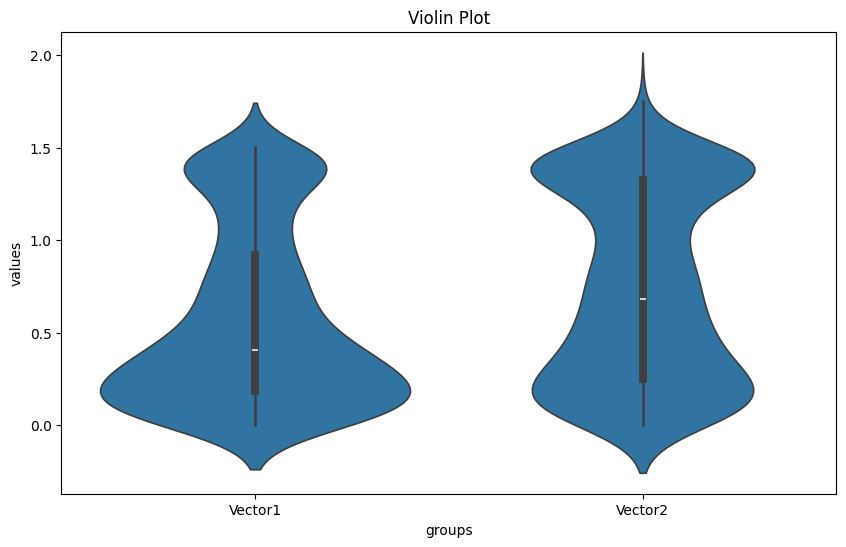

In [96]:
plot_violin_seaborn(true_diff,permute_diff)

In [100]:
model3 = train_model_with_categories(geneMat.T,dpt,catogory_tensor)

Epoch [100/2000], Loss: 1.6559, LR: 0.005000
Epoch [200/2000], Loss: 1.6501, LR: 0.005000
Epoch [300/2000], Loss: 1.6585, LR: 0.005000
Early stopping at epoch 400


In [ ]:
model_batch = model2.K.detach()
permute_batch = model_batch[:,new]
true_batch = model_batch[:,~new]
true_diff = np.abs(true_batch[0,:] - true_batch[1,:] )
permute_diff = np.abs(permute_batch[0,:] - permute_batch[1,:] )
plot_violin_seaborn(true_diff,permute_diff)

In [112]:

def compare_batch_differences(model_K, mask, labels=['True', 'Permuted'], 
                            title='Batch Effect Comparison',
                            figsize=(10, 6),
                            palette='Set2',
                            show_stats=True):
    """
    Compare and visualize the differences between batches for true and permuted data.
    
    Parameters:
    -----------
    model_K : torch.Tensor or numpy.ndarray
        The K matrix from the model (batch × genes)
    mask : numpy.ndarray
        Boolean mask for selecting genes
    labels : list
        Labels for the two groups [true_label, permuted_label]
    title : str
        Plot title
    figsize : tuple
        Figure size (width, height)
    palette : str
        Color palette for the violin plots
    show_stats : bool
        Whether to show statistical test results
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    stats_dict : dict
        Dictionary containing statistical information
    """
    # Convert to numpy if tensor
    if torch.is_tensor(model_K):
        model_K = model_K.detach().numpy()
    
    # Split data based on mask
    true_batch = model_K[:, ~mask]
    permute_batch = model_K[:, mask]
    
    # Calculate absolute differences
    true_diff = np.abs(true_batch[0, :] - true_batch[1, :])
    permute_diff = np.abs(permute_batch[0, :] - permute_batch[1, :])
    
    # Create DataFrame for seaborn
    df = pd.DataFrame({
        'Difference': np.concatenate([true_diff, permute_diff]),
        'Group': [labels[0]]*len(true_diff) + [labels[1]]*len(permute_diff)
    })
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create violin plot
    sns.violinplot(data=df, x='Group', y='Difference', 
                  inner='box', scale='width',
                  palette=palette)
    
    # Add individual points with jitter
    sns.stripplot(data=df, x='Group', y='Difference',
                 size=2, color='.3', alpha=0.2)
    
    # Calculate statistics
    stats_dict = {
        f'{labels[0]} mean': np.mean(true_diff),
        f'{labels[0]} std': np.std(true_diff),
        f'{labels[1]} mean': np.mean(permute_diff),
        f'{labels[1]} std': np.std(permute_diff),
    }
    
    if show_stats:
        # Perform statistical test
        stat, p_value = stats.mannwhitneyu(true_diff, permute_diff)
        stats_dict['p_value'] = p_value
        
        # Add statistical annotation
        y_max = max(true_diff.max(), permute_diff.max())
        plt.text(0.5, y_max*1.1, f'p-value: {p_value:.2e}',
                horizontalalignment='center')
        
        # Add mean lines
        plt.axhline(y=np.mean(true_diff), color='r', 
                   linestyle='--', alpha=0.5)
        plt.axhline(y=np.mean(permute_diff), color='r', 
                   linestyle='--', alpha=0.5)
        
        # Add summary statistics
        stats_text = (
            f'{labels[0]} mean: {stats_dict[f"{labels[0]} mean"]:.3f}\n'
            f'{labels[0]} std: {stats_dict[f"{labels[0]} std"]:.3f}\n'
            f'{labels[1]} mean: {stats_dict[f"{labels[1]} mean"]:.3f}\n'
            f'{labels[1]} std: {stats_dict[f"{labels[1]} std"]:.3f}'
        )
        plt.text(1.2, np.mean([true_diff.mean(), permute_diff.mean()]),
                stats_text, fontsize=8)
    
    # Customize plot
    plt.title(title)
    plt.xlabel('Groups')
    plt.ylabel('Absolute Difference')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, stats_dict

In [104]:
new

array([ True,  True,  True, ..., False, False, False])

In [108]:
model3[0]

WeightedPolynomialRegression()

/tmp/ipykernel_1916060/4145655417.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Group', y='Difference',
/tmp/ipykernel_1916060/4145655417.py:55: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='Group', y='Difference',


NameError: name 'stats' is not defined

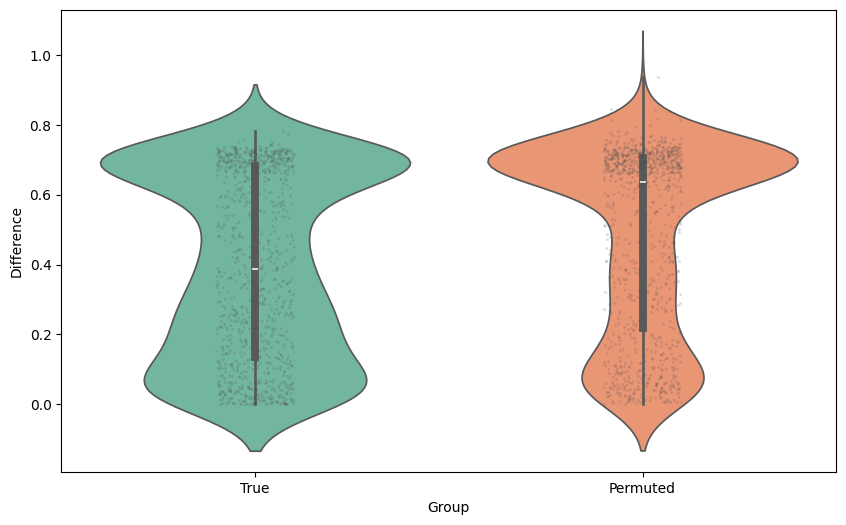

In [113]:
compare_batch_differences(model3[0].K,mask=new)